In [2]:
# Retail Demand Forecasting System
# Objective: Build a demand forecasting model for retail sales using time series techniques to support business planning.


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

print("Libraries imported successfully")


Libraries imported successfully


In [4]:
df = pd.read_csv("../data/walmart_sales.csv", parse_dates=['Date'])
df = df.sort_values("Date")

df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
277665,29,5,2010-02-05,15552.08,False
277808,29,6,2010-02-05,3200.22,False
277951,29,7,2010-02-05,10820.05,False
278094,29,8,2010-02-05,20055.64,False


In [5]:
ts = df.groupby("Date")["Weekly_Sales"].sum()

# Enforce weekly frequency (Walmart data is weekly)
ts = ts.asfreq("W-FRI")
ts.head()


Date
2010-02-05    49750740.50
2010-02-12    48336677.63
2010-02-19    48276993.78
2010-02-26    43968571.13
2010-03-05    46871470.30
Freq: W-FRI, Name: Weekly_Sales, dtype: float64

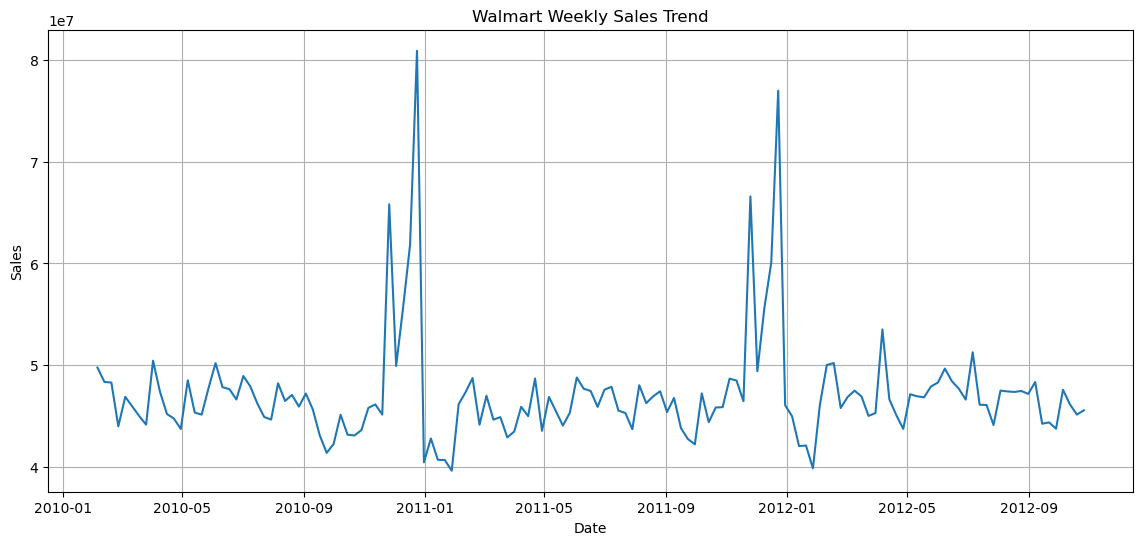

In [6]:
plt.figure(figsize=(14,6))
plt.plot(ts)
plt.title("Walmart Weekly Sales Trend")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


In [7]:
train = ts[:'2011-12-31']
test = ts['2012-01-01':]

print("Train size:", len(train))
print("Test size:", len(test))


Train size: 100
Test size: 43


In [8]:
baseline_pred = test.shift(1)

baseline_rmse = ((test - baseline_pred)**2).mean()**0.5

print("Baseline RMSE:", baseline_rmse)


Baseline RMSE: 2806754.954243491


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,1,1,52),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result = sarima_model.fit()

sarima_forecast = sarima_result.get_forecast(steps=len(test)).predicted_mean

sarima_rmse = ((test - sarima_forecast)**2).mean() ** 0.5

print("SARIMA RMSE:", sarima_rmse)


C:\Users\ADITYA SATAPATHY\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


SARIMA RMSE: 1603804.6021319784


In [10]:
!pip install prophet


In [11]:
from prophet import Prophet

prophet_df = ts.reset_index()
prophet_df.columns = ['ds', 'y']

prophet_train = prophet_df[prophet_df['ds'] <= train.index.max()]

model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

future = model.make_future_dataframe(periods=len(test), freq='W')
forecast = model.predict(future)

prophet_forecast = forecast.set_index('ds')['yhat'][-len(test):]

prophet_rmse = ((test.values - prophet_forecast.values)**2).mean() ** 0.5

print("Prophet RMSE:", prophet_rmse)


14:16:59 - cmdstanpy - INFO - Chain [1] start processing
14:16:59 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 2540793.7277775505


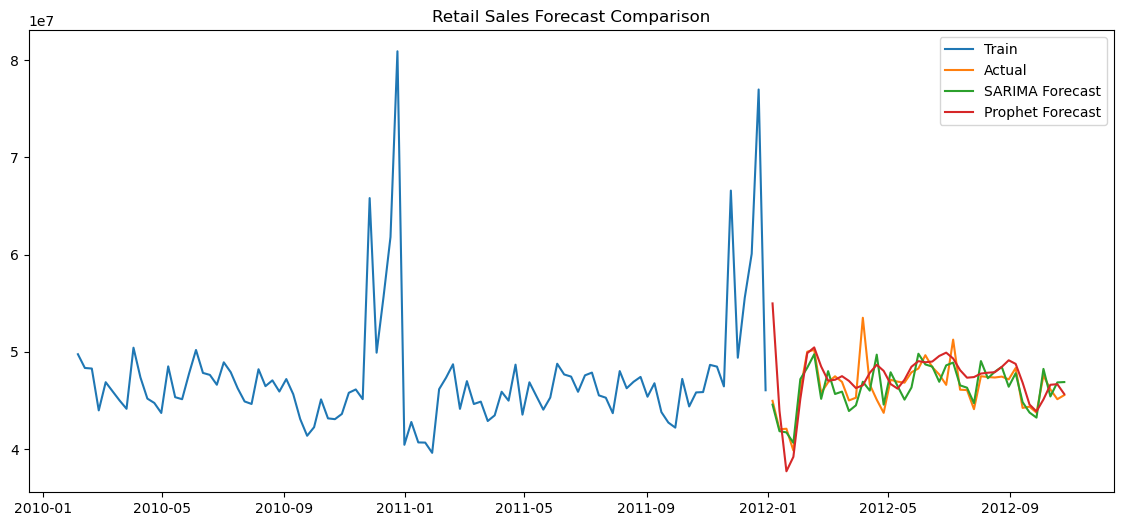

In [12]:
plt.figure(figsize=(14,6))

plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast")
plt.plot(test.index, prophet_forecast.values, label="Prophet Forecast")

plt.legend()
plt.title("Retail Sales Forecast Comparison")
plt.show()


In [13]:
export_df = pd.DataFrame({
    "Date": test.index,
    "Actual_Sales": test.values,
    "SARIMA_Forecast": sarima_forecast.values,
    "Prophet_Forecast": prophet_forecast.values
})

export_df.to_csv("../outputs/forecast_output_for_tableau.csv", index=False)

print("Export done for Tableau")


Export done for Tableau
